In [9]:
# Install OpenAI Gym dependencies
# !pip install Box2D
# !pip install box2d-py
# !pip install gym[all]
# !pip install Box2D
# !pip install box2d box2d-kengz
# !pip install autograd
# !pip install numpy
# Imports
%matplotlib inline
import gym
import pygame
import matplotlib.pyplot as plt
from gym.utils.play import play
import numpy as np
from autograd import grad
from scipy.signal import savgol_filter

# DL libraries
from keras.layers import Dense, Activation
from keras.models import Sequential, load_model

In [10]:
class ComparisonPlot:

    def __init__(self,title=None):
        plt.rcParams["figure.figsize"] = (7,5)
        self.fig,self.ax = plt.subplots()
        self.ax.set_xlabel('Episodes')
        self.ax.set_ylabel('Average cumulative reward')
        # self.ax.set_xscale('log')
        if title is not None:
            self.ax.set_title(title)

    def add_curve(self,x,y,label=None):
        ''' x: vector of parameter values
        y: vector of associated mean reward for the parameter values in x
        label: string to appear as label in plot legend '''
        if label is not None:
            self.ax.plot(x,y,label=label)
        else:
            self.ax.plot(x,y)

    def save(self,name='test.png'):
        ''' name: string for filename of saved figure '''
        self.ax.legend()
        self.fig.savefig(name,dpi=300)


def smooth(y, window, poly=1):
    '''
    y: vector to be smoothed
    window: size of the smoothing window '''
    return savgol_filter(y,window,poly)

## Environment

In [11]:
env_name = 'LunarLander-v2' # Create environment, source: https://www.gymlibrary.ml/environments
env = gym.make(env_name) 

## Deep Q Learning

In [12]:
class ReplayBuffer(object):
    
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_counter = 0
        self.input_shape = input_shape
        self.state_memory = np.zeros((self.mem_size, input_shape))
        self.new_state_memory = np.zeros((self.mem_size, input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions), dtype=np.int8)
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)
    
    def store_transition(self, state, action, reward, new_state, done):
        index = self.mem_counter % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = new_state
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - int(done)
        actions = np.zeros(self.action_memory.shape[1])
        actions[action] = 1
        self.action_memory[index] = actions
        self.mem_counter += 1
        
    def sample_buffer(self, batch_size):
        max_memory = min(self.mem_counter, self.mem_size)
        batch = np.random.choice(max_memory, batch_size)
        
        states = self.state_memory[batch]
        new_states = self.new_state_memory[batch]
        rewards = self.reward_memory[batch]
        actions = self.action_memory[batch]
        terminal = self.terminal_memory[batch]
        
        return states, actions, rewards, new_states, terminal 

In [13]:
def build_dqn(lr, n_actions, input_dims, fc1_dims, fc2_dims):
    model = Sequential([
        Dense(fc1_dims, input_shape=(input_dims, )),
        Activation('relu'),
        Dense(fc2_dims),
        Activation('relu'),
        Dense(n_actions)
    ])
    model.compile(optimizer='adam', loss='mse')
    
    return model
    

In [14]:
class DQN_Agent(object):
    def __init__(self, alpha, gamma, n_actions, epsilon, batch_size, input_dims, mem_size=1000000, min_epsilon=0.05, epsilon_decay=0.05):
        np.random.RandomState(seed=None)
        self.action_space = np.arange(n_actions)
        self.gamma = gamma 
        self.epsilon = epsilon
        self.alpha = alpha
        self.batch_size = batch_size
        self.memory = ReplayBuffer(mem_size, input_dims, n_actions)
        self.q_network = build_dqn(alpha, n_actions, input_dims, fc1_dims=128, fc2_dims=128)
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay
        
    def update_epsilon(self):
        if self.epsilon <= self.min_epsilon:
            self.epsilon = self.min_epsilon
        else:
            self.epsilon *= self.epsilon_decay
    
        
    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)
        
    def select_action(self,state):
        state = state[np.newaxis, :]
        
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            actions = self.q_network.predict(state)
            action = np.argmax(actions)
        
        return action
    
    
    def learn(self):
        if self.memory.mem_counter < self.batch_size:
            return
        state, action, reward, new_state, done = self.memory.sample_buffer(self.batch_size)
        
        action_values = np.array(self.action_space, dtype=np.int8)
        action_indices = np.dot(action, action_values)
        
        
        q_vals = self.q_network.predict(state)
        q_next = self.q_network.predict(new_state)
        
        q_target = q_vals.copy()
        
        batch_index = np.arange(self.batch_size, dtype=np.int32)
        td = reward + self.gamma * np.argmax(q_vals, axis=1)*done
        
        q_target[batch_index, action_indices] = td 
        
        _ = self.q_network.fit(state, q_target, verbose=0)
        

## Linear function approximation using Gradient SARSA

In [15]:
class FA_Agent(object):
    
    def __init__(self, n_actions, state_dims, alpha, epsilon, gamma, epsilon_decay=0.9, min_epsilon=0.05):
        np.random.RandomState(seed=None)
        self.action_space = np.arange(n_actions)
        self.gamma = gamma 
        self.epsilon = epsilon
        self.alpha = alpha
        self.state_dims = state_dims
        self.weights = np.random.rand(self.state_dims, n_actions)
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay
    
    def update_epsilon(self):
        if self.epsilon <= self.min_epsilon:
            self.epsilon = self.min_epsilon
        else:
            self.epsilon *= self.epsilon_decay
    
    def approximate(self, weights, state, action):
        return np.dot(state, weights)[action]
    
    def calc_grad(self, weights, state, action):
        gradient = grad(self.approximate)
        return gradient(weights, state, action)
    
    def select_action(self, state):
        q_values = []
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            for action in self.action_space:
                q_values.append(self.approximate(self.weights, state, action))
                action = np.argmax(q_values)
        return action
    
    def update(self, state, next_state, action, next_action, reward, done):
        q = self.approximate(self.weights, state, action)
        q_next = self.approximate(self.weights, next_state, next_action)
        q_grad = self.calc_grad(self.weights, state, action)
        
        if done:
            self.weights += self.alpha * (reward - q) * q_grad
        else:      
            self.weights += self.alpha * (reward + self.gamma * q_next - q) * q_grad

## Training and evaluating the LFA Agent on the Lunar Lander Task

Finished rep: 0
Finished rep: 1
Finished rep: 2
(3, 10)
Finished rep: 0
Finished rep: 1
Finished rep: 2
(6, 10)
Finished rep: 0
Finished rep: 1
Finished rep: 2
(9, 10)
Finished rep: 0
Finished rep: 1
Finished rep: 2
(12, 10)
Finished rep: 0
Finished rep: 1
Finished rep: 2
(15, 10)


KeyboardInterrupt: 

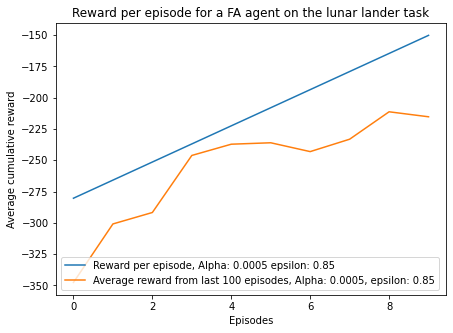

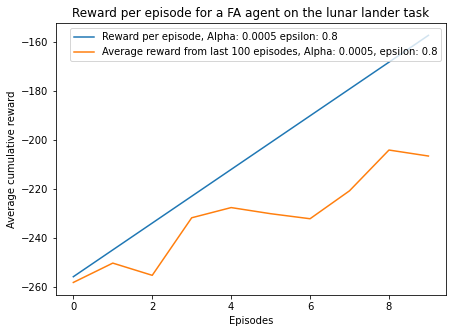

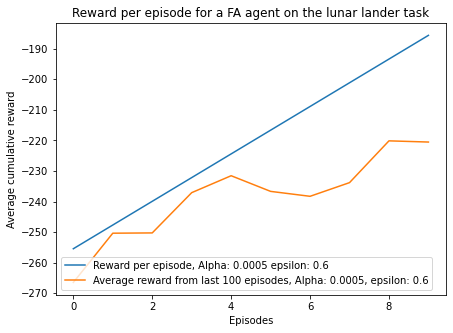

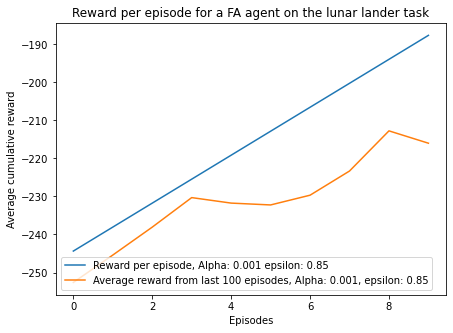

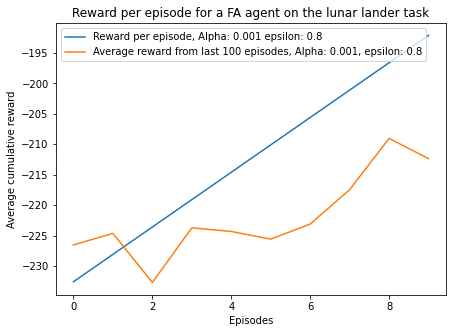

In [26]:
max_timesteps = 1000
reps = 3
n_episodes = 10
alphas = [0.0005, 0.001, 0.01]
gamma = 0.99
epsilons = [0.85, 0.8, 0.6]
    
def training_loop_SARSA_LFA(agent):
    done = False
    score = 0
    state = env.reset()
    timestep = 0
    while not done:
            if timestep == max_timesteps:
                done = True
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            score += reward
            next_action = agent.select_action(next_state)
            agent.update(state, next_state, action, next_action, reward, done)
            state = next_state
            timestep += 1
            # env.render() # Uncomment for rendering
    return score
    

for alpha in alphas:
    for epsilon in epsilons:
        rewards_per_rep = []
        avgs_from_last_hunderd = []
        for rep in range(reps):
            agent = FA_Agent(n_actions=env.action_space.n, state_dims=env.observation_space.shape[0], alpha=alpha, epsilon=epsilon, gamma=0.99)
            reward_per_ep = []
            avg_scores_per_ep = []
            for ep in range(n_episodes):
                score = training_loop_SARSA_LFA(agent)
                reward_per_ep.append(score)
                avg_score = np.mean(reward_per_ep[max(0,ep-100):(ep+1)])
                avg_scores_per_ep.append(avg_score)
                if ep%10 == 0:
                    agent.update_epsilon()
                    # print('episode:', ep, 'score:', score, 'avg score:', avg_score)

            rewards_per_rep.append(reward_per_ep)
            avgs_from_last_hunderd.append(avg_scores_per_ep)
            print('Finished rep:', rep)

        avg_rewards_per_eps = np.mean(rewards_per_rep, axis=0)
        all_avgs_from_last_hunderd = np.mean(avgs_from_last_hunderd, axis=0)
        print(np.shape(avgs_from_last_hunderd))

        comparison_plot = ComparisonPlot(title="Reward per episode for a FA agent on the lunar lander task")
        comparison_plot.add_curve(np.arange(n_episodes), y=smooth(avg_rewards_per_eps, 10), label='Reward per episode, Alpha: %s epsilon: %s' % (alpha, epsilon))
        comparison_plot.add_curve(np.arange(n_episodes), y=all_avgs_from_last_hunderd, label='Average reward from last 100 episodes, Alpha: %s, epsilon: %s' % (alpha, epsilon))
        file_name = 'fa alpha: %s, epsilon: %s.jpg' % (alpha, epsilon)
        comparison_plot.save(file_name)

## Training and evaluating the DQN Agent on the Lunar Lander Task

In [27]:
max_timesteps = 1000
reps = 5
n_episodes = 600
alpha = [0.0005, 0.001, 0.01]
gamma = 0.99
epsilon = [0.85, 0.8, 0.6]

def training_loop_DQN(agent):
    done = False
    score = 0
    state = env.reset()
    timestep = 0
    while not done:
            if timestep == max_timesteps:
                done = True
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            score += reward
            agent.remember(state, action, reward, next_state, done)
            next_action = agent.select_action(next_state)
            agent.learn()
            state = next_state
            timestep += 1
            # env.render() # Uncomment for rendering
    return score

for alpha in alphas:
    for epsilon in epsilons:
        rewards_per_rep = []
        avgs_from_last_hunderd = []
        for rep in range(reps):
            agent = DQN_Agent(gamma=gamma, epsilon=epsilon, alpha=alpha, input_dims=env.observation_space.shape[0], n_actions=env.action_space.n, batch_size=64)
            reward_per_ep = []
            for ep in range(n_episodes):
                score = training_loop_DQN(agent)
                reward_per_ep.append(score)
                avg_score = np.mean(reward_per_ep[max(0,ep-100):(ep+1)])
                if ep%10 == 0:
                    agent.update_epsilon()
                    # print('episode:', ep, 'score:', score, 'avg score:', avg_score)

        rewards_per_rep.append(reward_per_ep)
        avgs_from_last_hunderd.append(avg_score)
        print('Finished rep:', rep)

        avg_rewards_per_eps = np.mean(rewards_per_rep, axis=0)
        all_avgs_from_last_hunderd = np.mean(avgs_from_last_hunderd, axis=0)

        comparison_plot = ComparisonPlot(title="Reward per episode for a DQN agent on the lunar lander task")
        comparison_plot.add_curve(np.arange(n_episodes), y=smooth(avg_rewards_per_eps, 10), label='Reward per episode, Alpha: %s epsilon: %s' % (alpha, epsilon))
        comparison_plot.add_curve(np.arange(n_episodes), y=all_avgs_from_last_hunderd, label='Average reward from last 100 episodes, Alpha: %s, epsilon: %s' % (alpha, epsilon))
        file_name = 'dqn alpha: %s, epsilon: %s.jpg' % (alpha, epsilon)
        comparison_plot.save(file_name)

AttributeError: 'DQN_Agent' object has no attribute 'q_eval'